#Problème n°1

La bonne transmission de signaux électromagnétique dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un milliers de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [9]:
# Local clone
! git clone https://github.com/nanopiero/CML_processing_by_ML.git

fatal: destination path 'CML_processing_by_ML' already exists and is not an empty directory.


In [10]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np

import sys
sys.path.append('CML_processing_by_ML')

from utils.utils_probleme1 import create_dataloader

In [35]:
from os.path import join, isdir, isfile
from os import listdir as ls
import copy

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
from numba import jit
from scipy.ndimage import gaussian_filter1d

KERNEL = torch.tensor(np.concatenate([np.arange(0.025,0.5,0.025), np.array([1]), np.zeros(19)]), dtype=torch.float32)

def simulate_neyman_scott_process_1d(h, theta, p, duration):
    """
    Simulate a 1D Neyman-Scott process as a function of time.

    Parameters:
    - h: Intensity of the Poisson process for parent events.
    - theta: Mean of the Poisson distribution for the number of offspring per parent event.
    - p: Standard deviation of the Gaussian distribution for the timing of offspring events relative to their parent.
    - duration: Duration of the process.

    Returns:
    - parent_times: A list of event times for parent events.
    - offspring_times: A list of event times for all offspring events.
    """
    # Simulate parent events
    expected_parents = h * duration
    parent_events = np.random.exponential(1/h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        # Number of offspring for each parent
        num_offspring = np.random.poisson(theta)
        # Offspring times relative to parent
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        # Filter offspring times to keep only those within the duration
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    return np.sort(parent_times), np.sort(offspring_times)


@jit(nopython=True)
def simulate_neyman_scott_process_1d_jit(h, theta, p, duration):
    """
    Simulate a 1D Neyman-Scott process as a function of time.

    Parameters:
    - h: Intensity of the Poisson process for parent events.
    - theta: Mean of the Poisson distribution for the number of offspring per parent event.
    - p: Standard deviation of the Gaussian distribution for the timing of offspring events relative to their parent.
    - duration: Duration of the process.

    Returns:
    - parent_times: A sorted array of event times for parent events.
    - offspring_times: A sorted array of event times for all offspring events.
    """
    # Simulate parent events
    expected_parents = h * duration
    parent_events = np.random.exponential(1 / h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        # Number of offspring for each parent
        num_offspring = np.random.poisson(theta)
        # Offspring times relative to parent
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        # Filter offspring times to keep only those within the duration
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    return np.sort(parent_times), np.sort(np.array(offspring_times))


from scipy.ndimage import gaussian_filter1d
def smooth_events_with_gaussian_window(event_times, duration, sigma, resolution=1):
    """
    Smooth event occurrences over time using a Gaussian window.

    Parameters:
    - event_times: A numpy array of event times.
    - duration: The total duration of the simulation, in seconds.
    - sigma: The standard deviation for the Gaussian kernel, controls the smoothing.
    - resolution: The time resolution of the simulation (default is 1 second).

    Returns:
    - A tuple containing the time series and the smoothed event density.
    """
    # Create a time series of event occurrences
    time_series_length = int(duration / resolution)
    event_series = np.zeros(time_series_length)

    # Mark the occurrences of events in the time series
    for time in event_times:
        if time < duration:
            index = int(time / resolution)
            event_series[index] += 1

    # Apply Gaussian window smoothing
    smoothed_series = gaussian_filter1d(event_series, sigma=sigma/resolution, mode='constant')

    # Generate time points for the x-axis
    times = np.arange(0, duration, resolution)

    return times, smoothed_series



def convert(x):
  return 0.1*x**0.7

# @torch.jit.script
def apply_conv1d_with_custom_kernel(signal, kernel):
    """
    Apply a 1D convolution to a signal with a custom kernel using PyTorch.

    Parameters:
    - signal: A 1D PyTorch tensor representing the input signal.
    - kernel: A 1D PyTorch tensor representing the custom convolutional kernel.
    - stride: The stride of the convolution. Defaults to 1.

    Returns:
    - The convolved signal as a 1D PyTorch tensor.
    """
    # Ensure the signal and kernel are properly formatted for conv1d
    signal = signal.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Add batch and out_channels dimensions

    # Calculate padding to maintain output size
    padding = (kernel.size(-1) - 1) // 2

    # Apply the 1D convolution
    convolved_signal = F.conv1d(signal, kernel, padding=padding)

    # Remove added dimensions to return to original signal shape
    convolved_signal = convolved_signal.squeeze(0).squeeze(0)

    return convolved_signal

# @torch.jit.script
def generate_random_sinusoidal_process(length, mean_poisson=10., phase_range=(0, 2 * np.pi)):
    """
    Generate a signal composed of a polynomial of sinusoids with random phases, coefficients, and periods.

    Parameters:
    - length: The number of points in the generated signal.
    - mean_poisson: The mean of the Poisson distribution for determining the number of components.
    - phase_range: The range (min, max) of possible phases for the sinusoids.
    - time_scale: Scale for the time axis (default 1.0).

    Returns:
    - A PyTorch tensor representing the generated signal.
    """
    # Determine the number of sinusoidal components
    num_components = 1 + int(torch.poisson(torch.tensor(mean_poisson)).item())

    # Sample coefficients from a normal distribution
    coefficients = torch.randn(num_components)

    # Sample periods from a uniform distribution between 120 and 24*60
    periods = torch.randint(low=240, high=24*60, size=[num_components]).float()

    # Time axis
    t = torch.linspace(0, length, steps=length)

    # Initialize the signal
    signal = torch.zeros(length)

    # Generate each sinusoidal component
    for i in range(num_components):
        # Random phase for each component
        phase = torch.rand(1) * (phase_range[1] - phase_range[0]) + phase_range[0]

        # Sinusoidal component
        component = coefficients[i] * torch.sin(2 * np.pi * t / periods[i] + phase)

        # Add the component to the signal
        signal += component
    signal /= num_components
    signal /= 2
    return signal


def get_gaussian_noise(signal, noise_scale_func):
    """
    Apply Gaussian noise to a signal where the noise standard deviation varies non-linearly with the signal intensity.

    Parameters:
    - signal: A PyTorch tensor representing the input signal.
    - noise_scale_func: A function defining how the noise standard deviation scales with the signal intensity.

    Returns:
    - The signal with applied Gaussian noise.
    """
    # Compute the standard deviation of the noise for each point in the signal
    noise_std = noise_scale_func(signal)

    # Generate the Gaussian noise
    noise = torch.randn_like(signal) * noise_std

    return noise

# Define a non-linear noise scale function
def noise_scale_func(signal_intensity):
    # Example: Standard deviation of the noise scales with the square of the signal intensity
    return 0.1*torch.abs(1 + signal_intensity) ** 0.75



def generate_pair(duration, distance, dtheta, dp):
    # ppp_intensity is inversely proportional to the distance

    ppp_intensity = 0.05 * distance
    theta = 10. + dtheta
    p = 3. + dp
    _, event_times = simulate_neyman_scott_process_1d(h=ppp_intensity, theta=10., p=3., duration=duration)

    times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=2)
    ground_truth_specific = torch.tensor(smoothed_series, dtype=torch.float32)
    ground_truth = ground_truth_specific * 1/distance

    converted_smoothed_series = convert(smoothed_series)
    converted_smoothed_series = torch.tensor(converted_smoothed_series, dtype=torch.float32)
    convolved_smoothed_series = apply_conv1d_with_custom_kernel(converted_smoothed_series, KERNEL)

    lf_noise = generate_random_sinusoidal_process(duration)
    hf_noise = get_gaussian_noise(convolved_smoothed_series, noise_scale_func)

    noisy1_series = convolved_smoothed_series + lf_noise
    noisy_series = noisy1_series + hf_noise

    return ground_truth, noisy_series


#################################################################################################################
#################################################################################################################
#############################################      DATASET       ################################################
#################################################################################################################
#################################################################################################################




# Step 1: Define the Dataset Class
class TensorPairDataset(Dataset):
    def __init__(self, duration, idx2distance):
        self.duration = duration
        self.idx2distance = idx2distance
        self.num_cmls = len(idx2distance)
        self.indices = sorted(idx2distance.keys())

    def __len__(self):
        return self.num_cmls

    def __getitem__(self, i):
        idx = self.indices[i]
        dist = self.idx2distance[idx]
        dtheta = idx/1000.
        dp = 1 - idx/1000.
        ground_truth, noisy_series = generate_pair(self.duration, dist, dtheta, dp)

        # normalisation:
        noisy_series = 0.3 * noisy_series
        return idx, dist, ground_truth, noisy_series

# Step 2: Create the DataLoader
def create_dataloader(duration, idx2distance, batch_size, shuffle=True):
    dataset = TensorPairDataset(duration, idx2distance)
    # num_workers = 2 for colab
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [44]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader.
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

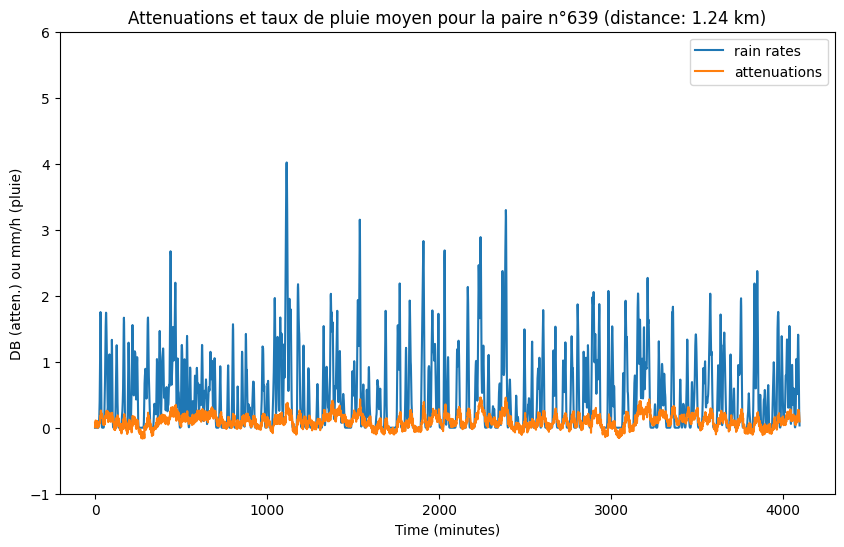

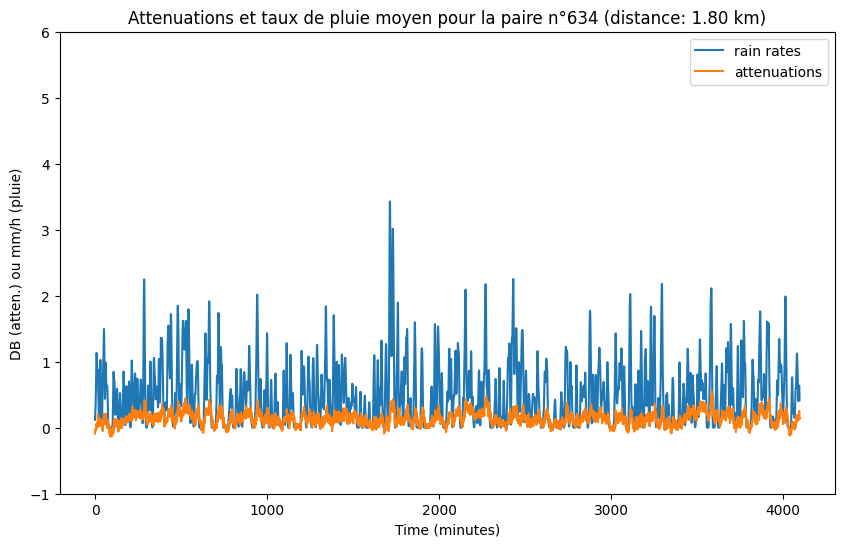

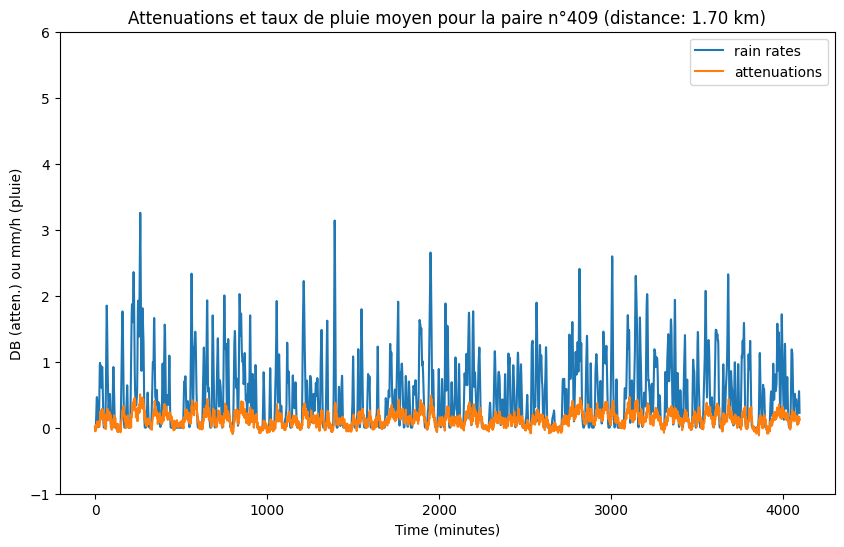

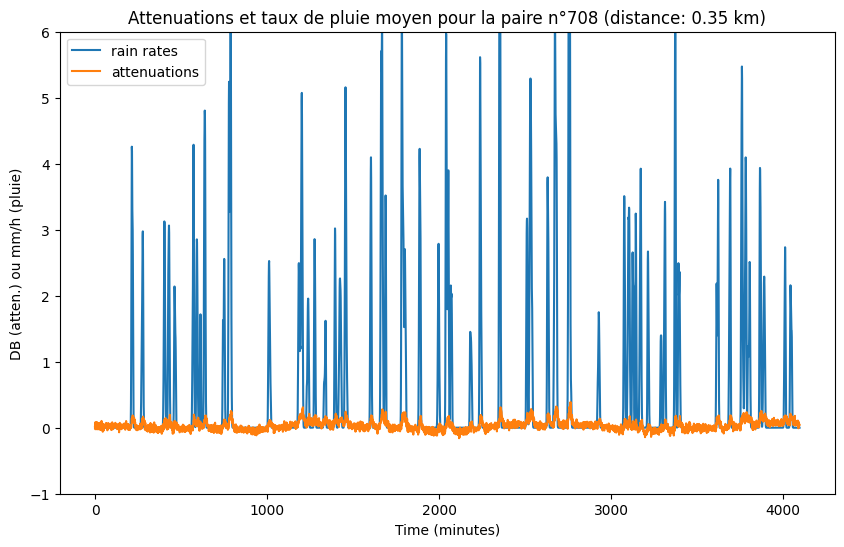

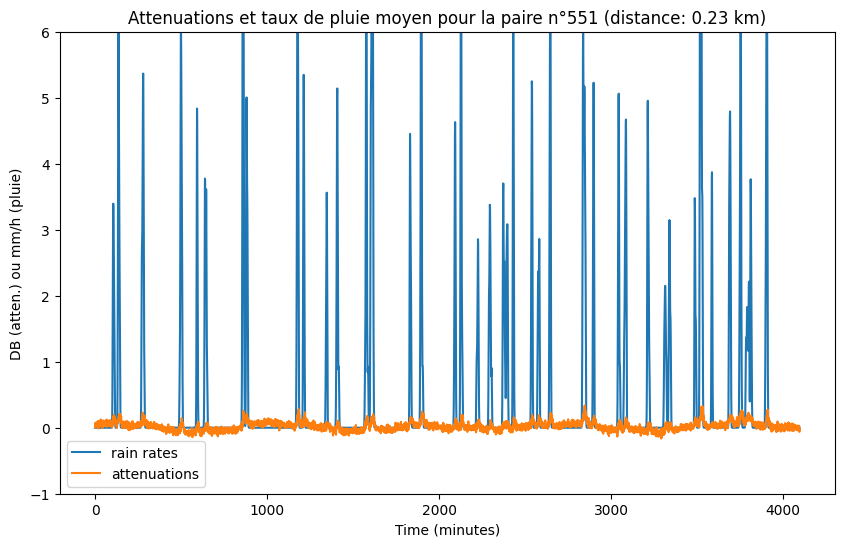

In [45]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

In [46]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x




class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x




####################################################################################################################################
######################################## class UNet ################################################################################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

In [ ]:
# Same weights for all CMLs
n_channels = ...
n_classes = ...
model = UNet1D(n_channels, n_classes, size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 300  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [ ]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La méthode suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [ ]:
def apply_perceptron(self, UNet_output, ids):
    for i in range(ids.shape[0]):
        id = ids[i]
        # application de la première couche
        x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
        x = self.relu(x)
        # application de la seconde couche
        x = self.linears2[id](x)
        # correction multiplicative de UNet_output
        UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous()
    return UNet_output[:,0]


## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifique.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids du UNet et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité